<a href="https://colab.research.google.com/github/abs711/abs711.github.io/blob/main/Classifying_Politicians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Spectral Clustering and Semi-supervised Learning**



In [ ]:
from google.colab import drive


# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn as skl


Data Description

In [ ]:
descript_path = '/content/drive/My Drive/AMATH 582/Ass4/house-votes-84.names'

#pd.read_csv(descript_path,sep='\t',header=None)

with open(descript_path) as f:
    print(f.read())

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

Data Loading

In [ ]:
data_path = '/content/drive/My Drive/AMATH 582/Ass4/house-votes-84.data'

df_table = pd.read_csv(data_path, sep=',',header=None)

df_table


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


In [ ]:
df_array = np.array(df_table)

X = copy.copy(df_array[:,1:17]) # Create Inputs
X[X=='y'] = 1
X[X=='n'] = -1
X[X=='?'] = 0

Y = copy.copy(df_array[:,0]) # Create labels
Y[Y=='republican'] = -1
Y[Y=='democrat'] = 1

In [ ]:
Y.shape

(435,)

Sorted Reps and Dems

In [ ]:
y_idx = Y.argsort()

Y_sort = Y[y_idx]


## **Spectral Clustering**

Computing pairwise distances

In [ ]:
import scipy.spatial 

dist = scipy.spatial.distance_matrix( X, X, p =2)

dist.mean()
dist.min()


0.0

Computing Weight Matrix

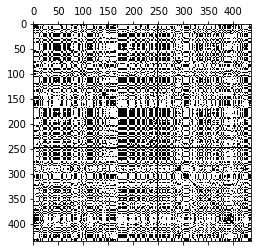

In [ ]:
# compute the weight matrix W for the vertices of our graph 

def eta(dis, l):

  val = np.exp( - (dis**2)/(2*l**2) ) 
  
  return val.astype(float)

Ls = 2.2#2.3#*dist.mean()

W = eta(dist, Ls)

plt.spy(W>= 0.1)

Constructing The Graph

In [ ]:
# compute Laplacian matrices 
def build_graph(W):
  d = np.sum(W, axis=1) # degree vector

  D = np.diag(d)
  Ds = np.diag(1/np.sqrt(d))
  Di = np.diag(1/d)


  L = D - W # unnormalized
  return L

L = build_graph(W)  
#Ln = np.dot(Ds, np.dot((D - W),Ds)) # normalized

In [ ]:
## EIGENDECOMPOSITION

# UNNORMALIZED LAPLACIAN
def compute_eigs(L):
  ll, VV = np.linalg.eigh(L)

# sorted eigenvalues and vectors 

  idx = ll.argsort()
  l = ll[idx]
  V = VV[:, idx]
  return l, V  

l, V = compute_eigs(L)

V_sort = V[y_idx,:] # All reps and then all dems

# #NORMALIZED LAPLACIAN
# lln, VVn = np.linalg.eigh(Ln)

# idxn = lln.argsort()
# ln = lln[idxn]
# Vn = VVn[:, idxn]

# print(l[0:17])

# print(ln[0:17])

In [ ]:
# plot eigenvalues 

import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(mode='markers',x=np.linspace(1, 434, 434),
    y=np.log(l[1:None]), name="Unnormalized Laplacian"),
    row=1, col=1
)

# fig.add_trace(
#     go.Scatter(mode='markers',x=np.linspace(1, 434, 434),
#     y=np.log(ln[1:None]), name="Normalized Laplacian"),
#     row=2, col=1
# )



# tight layout
fig['layout']['xaxis']['title']='Eigenvalue index'
# fig['layout']['xaxis2']['title']='Eigenvalue index'
fig['layout']['yaxis']['title']='Eigenvalue'
# fig['layout']['yaxis2']['title']='Eigenvalue'
fig.update_layout(width=1300, height=900)

fig.show()

#fig, ax = plt.subplots(1,2, figsize=(16,8))

#ax[0].plot(np.log(l[1:None]))
#ax[0].set_title('Unnormalized eigenvalues')
#ax[0].set_xlabel('index')
#ax[0].set_ylabel('$\lambda$')


#ax[1].plot(np.log(ln[1:None]))
#ax[1].set_title('Normalized eigenvalues')
#ax[0].set_xlabel('index')
#ax[0].set_ylabel('$\lambda$')

Ratio of consecutive eigenvalues

In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=np.linspace(1, 434, 434),
    y=np.log(l[2:None]/l[1:-1]), name="Unnormalized Laplacian"),
    row=1, col=1
)

Visualizing Clusters in the Eigenspace of the Laplacian 

---



In [ ]:
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(1, 1, 1, projection='3d')

# ax.scatter( V_sort[168:-1,1]/np.abs(V_sort[:,1]).max(), V_sort[168:-1,2]/np.abs(V_sort[:,2]).max(), V_sort[168:-1,3]/np.abs(V_sort[:,3]).max()  )
# ax.set_xlabel('$tq_1$')
# ax.set_ylabel('$tq_2$')
# ax.set_zlabel('$tq_3$')
# ax.set_title('Unnormalized embedding')

# ax.scatter( V_sort[0:168,1]/np.abs(V_sort[:,1]).max(), V_sort[0:168,2]/np.abs(V_sort[:,2]).max(), V_sort[0:168,3]/np.abs(V_sort[:,3]).max())

In [ ]:


# fig = go.Figure(data=[go.Scatter3d(mode='markers',x=V_sort[168:-1,1]/np.abs(V_sort[:,1]).max(),
#     y=V_sort[168:-1,2]/np.abs(V_sort[:,2]).max(),
#     z=V_sort[168:-1,3]/np.abs(V_sort[:,3]).max())])

# fig.add_trace(go.Scatter3d(mode='markers',x=V_sort[0:168,1]/np.abs(V_sort[:,1]).max(),
#     y=V_sort[0:168,2]/np.abs(V_sort[:,2]).max(),
#     z=V_sort[0:168,3]/np.abs(V_sort[:,3]).max()))
# # tight layout
# fig.update_layout(scene = dict(xaxis_title= "$tq_1$", yaxis_title= "$tq_2$", zaxis_title="$tq_3$"),width=600, height=600)

# fig.show()


# #fig = plt.figure(figsize=(20,10))
# #ax = fig.add_subplot(1, 2, 1, projection='3d')

# #ax.scatter( V[:,1]/np.abs(V[:,1]).max(), V[:,2]/np.abs(V[:,2]).max(), V[:,3]/np.abs(V[:,3]).max()  )
# #ax.set_xlabel('$tq_1$')
# #ax.set_ylabel('$tq_2$')
# #ax.set_zlabel('$tq_3$')
# #ax.set_title('Unnormalized embedding')

# #ax = fig.add_subplot(1, 2, 2, projection='3d')

# #ax.scatter( Vn[:,1]/np.abs(Vn[:,1]).max(), Vn[:,2]/np.abs(Vn[:,2]).max(), Vn[:,3]/np.abs(Vn[:,3]).max()  )
# #ax.set_xlabel('$q_1$')
# #ax.set_ylabel('$q_2$')
# #ax.set_zlabel('$q_3$')
# #ax.set_title('Normalized embedding')

In [ ]:
# fig = go.Figure(data=[go.Scatter3d(mode='markers',x=Vn[:,1]/np.abs(Vn[:,1]).max(),
#     y=Vn[:,2]/np.abs(Vn[:,2]).max(),
#     z=Vn[:,3]/np.abs(Vn[:,3]).max())])

# # tight layout
# fig.update_layout(scene = dict(xaxis_title= "$q_1$", yaxis_title= "$q_2$", zaxis_title="$q_3$"),width=800, height=800)

# fig.show()

In [ ]:
q1 = copy.copy(V[:,1]) #Fiedler vector
y_hat = np.sign(q1) #Assigning Classes
Y.shape

q1_sort = q1[y_idx]

Visualizing Misclassification

In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(mode='markers', y = q1_sort[168:-1], name="Dems"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(mode='markers', y = q1_sort[0:168], name="Reps"),
    row=1, col=1
)

In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(mode='markers', y = np.sign(q1_sort[168:-1]), name="Dems"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(mode='markers', y = np.sign(q1_sort[0:168]), name="Reps"),
    row=1, col=1
)

In [ ]:
# fig = make_subplots(rows=1, cols=1)

# fig.add_trace(
#     go.Scatter(mode='markers', y = Y, marker=dict(size=2.5), name="True"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(mode='markers', y = y_hat, marker=dict(size=2.5), name="Preds"),
#     row=1, col=1
# )

In [ ]:
# fig = make_subplots(rows=1, cols=2)

# fig.add_trace(
#     go.Scatter(mode='markers', y=Y-y_hat, name="y-y_hat"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(mode='markers', y=Y+y_hat, name="y+y_hat"),
#     row=1, col=2
# )

Classification Accuracy

In [ ]:
np.max([1-np.size(np.nonzero(Y-y_hat))/435,1-np.size(np.nonzero(Y+y_hat))/435])

0.8804597701149426

# **Length Scale Optimization**

In [ ]:
# def eta(dis, l):

#   val = np.exp( - (dis**2)/(2*l**2) ) 
  
#   return val.astype(float)

def run_the_whole_thing(dist,Ls):
  W = eta(dist, Ls) # get edge weights

  L = build_graph(W)  

  l, V = compute_eigs(L)

  q1 = copy.copy(V[:,1])
  y_hat = np.sign(q1) # Classify
  return y_hat


num_points = 100
num_trials = 30

Ls = np.delete(np.linspace(0,4,num_points+1),0) #remove 0

scores = np.zeros(num_points)

scores_std = np.zeros((num_points))

for i in range(len(Ls)):  
  trials = []
  for j in range(num_trials):
    y_hat = run_the_whole_thing(dist,Ls[i])

    trials.append(np.max([1-np.size(np.nonzero(Y-y_hat))/435,1-np.size(np.nonzero(Y+y_hat))/435]))

  scores[i] = np.mean(trials)
  scores_std[i] = np.std(trials)



In [ ]:
best_idx = np.intersect1d(np.where(scores == np.max(scores)),np.where(scores_std == np.min(scores_std))) #Find parameter with best accuracy and least variation in accuracy with trials

scores[best_idx]

Ls[best_idx]

array([1.16, 1.48, 2.12, 2.16, 2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 3.32,
       3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 , 3.64, 3.68, 3.72, 3.76,
       3.8 , 3.84, 3.88, 3.92, 3.96, 4.  ])

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(mode='markers',x = Ls, y=scores, name="mean"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(mode='markers',x = Ls, y=scores_std, name="std"),
    row=1, col=2
)

## **Semi-supervised Learning**

In [ ]:

M = 6#2,3,4,5,6 # Number of eigenvectors  

# Labelled Training Data 

J = 40#5#,10,20,40 ##50

F = V[:,0:M]


A = F[0:J,:]
b = Y[0:J]
b.shape

(40,)

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False).fit(A, b)

reg.intercept_

0.0

In [ ]:
# predict labels on entire data set 

# c_hat = reg.coef_
# Y_pred =  np.sign(np.dot(V[:, 0:M], c_hat)) 

Y_pred = np.sign(reg.predict(V[:, 0:M])) 



In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(mode='markers', y=Y-Y_pred, name="y-y_hat"),
    row=1, col=1
)

# fig.add_trace(
#     go.Scatter(mode='markers', y=Y+Y_pred, name="y+y_hat"),
#     row=1, col=2
# )

In [ ]:
np.max([1-np.size(np.nonzero(Y-Y_pred))/435,1-np.size(np.nonzero(Y+Y_pred))/435])

0.871264367816092